In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
import torch

In [ ]:
classifier = pipeline("zero-shot-classification",
    model="facebook/bart-large-mnli",
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    )

In [4]:
candidate_labels = {0: "Politics", 
                    1: "Sports", 
                    2: "Technology", 
                    3:"Entertainment",
                    4:"Business",}
df = pd.read_csv('../data/df_file.csv')


In [24]:
from sklearn.model_selection import train_test_split
# calib_df, test_df = train_test_split(df, test_size=0.5, random_state=42, shuffle=True)
# calib_df.to_csv('../data/calib_data.csv', index=False)
# test_df.to_csv('../data/test_data.csv', index=False)
calib_df = pd.read_csv('../data/calib_data.csv')
test_df = pd.read_csv('../data/test_data.csv')

In [5]:
classifier("This is a course about the Transformers library", list(candidate_labels.values()), multi_label=True)

{'sequence': 'This is a course about the Transformers library',
 'labels': ['Entertainment', 'Technology', 'Business', 'Sports', 'Politics'],
 'scores': [0.00952468067407608,
  0.002116578398272395,
  0.0005025901482440531,
  0.00019904744112864137,
  0.00011217956489417702]}

In [ ]:
classifier("Let's talk about technology", list(candidate_labels.values()), multi_label=True)

{'sequence': "Let's talk about technology",
 'labels': ['Technology', 'Business', 'Entertainment', 'Sports', 'Politics'],
 'scores': [0.9931901097297668,
  0.0002460118557792157,
  0.00015180729678831995,
  0.00012529001105576754,
  6.54403556836769e-05]}

In [61]:
def calib_data():
    for i in range(len(calib_df)):
        yield calib_df.iloc[i]['Text']
predictions = pd.DataFrame(columns=['Entertainment', 'Sports', 'Business', 'Politics', 'Technology'])
for out in classifier(calib_data(), 
                      list(candidate_labels.values()), 
                      multi_label=True):
    predictions = pd.concat([
        predictions, 
        pd.DataFrame(dict(zip(out['labels'], out['scores'])), index=[0])], 
        ignore_index=True)
predictions.to_csv('../data/calib_predictions.csv', index=False)


/var/folders/7h/662tdm8d6sn0krrht717wzmm0000gq/T/ipykernel_53768/1627200507.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([predictions, pd.DataFrame(dict(zip(out['labels'], out['scores'])), index=[0])], ignore_index=True)


In [63]:
def test_data():
    for i in range(len(test_df)):
        yield test_df.iloc[i]['Text']
predictions = pd.DataFrame(columns=['Entertainment', 'Sports', 'Business', 'Politics', 'Technology'])
for out in classifier(test_data(), 
                      list(candidate_labels.values()), 
                      multi_label=True):
    predictions = pd.concat([
        predictions, 
        pd.DataFrame(dict(zip(out['labels'], out['scores'])), index=[0])], 
        ignore_index=True)
predictions.to_csv('../data/test_predictions.csv', index=False)

/var/folders/7h/662tdm8d6sn0krrht717wzmm0000gq/T/ipykernel_53768/3813459614.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([


Load predicted probabilities

In [25]:
cal_probs = pd.read_csv('../data/calib_predictions.csv')[candidate_labels.values()]
cal_labels = pd.read_csv('../data/calib_data.csv')['Label']
val_probs = pd.read_csv('../data/test_predictions.csv')[candidate_labels.values()]
val_labels = pd.read_csv('../data/test_data.csv')['Label']

Use 1 - predicted probability as conformal score

In [67]:
cal_scores = 1 - np.take_along_axis(cal_probs.values, cal_labels.values[:,None], axis=1).ravel()
# qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# prediction_sets = 1- val_probs.values <= qhat
# predictions = {idx: np.arange(5)[prediction_sets[idx]] for idx in range(len(prediction_sets))}
# np.mean([label in pset for label, pset in zip(test_df['Label'], predictions.values())])

In [68]:
# check coverage for different alpha levels
n = len(cal_scores)
alphas = np.arange(.05, 1, .05)
coverage = []
for alpha in alphas:
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    prediction_sets = 1- val_probs.values <= qhat
    pred_set_df = pd.DataFrame(prediction_sets, columns=list(candidate_labels.values()))
    pred_set_df['true_label'] = test_df['Label'].map(candidate_labels).values
    pred_set_df['covered'] = pred_set_df.apply(lambda x: x[x['true_label']], axis=1)
    pred_set_df['set_size'] = pred_set_df.apply(lambda x: x[list(candidate_labels.values())].sum(), axis=1)
    pred_set_df['alpha'] = alpha
    coverage.append(pred_set_df)
coverage = pd.concat(coverage)
coverage

,Politics,Sports,Technology,Entertainment,Business,true_label,covered,set_size,alpha
0,True,False,False,False,False,Politics,True,1,0.05
1,False,True,True,False,True,Sports,True,3,0.05
2,False,False,False,True,True,Entertainment,True,2,0.05
3,True,False,False,False,True,Politics,True,2,0.05
4,True,True,True,True,True,Technology,True,5,0.05
...,...,...,...,...,...,...,...,...,...
1108,True,False,False,False,False,Entertainment,False,1,0.95
1109,False,False,False,False,False,Technology,False,0,0.95
1110,False,False,False,False,False,Business,False,0,0.95
1111,False,False,False,False,False,Technology,False,0,0.95


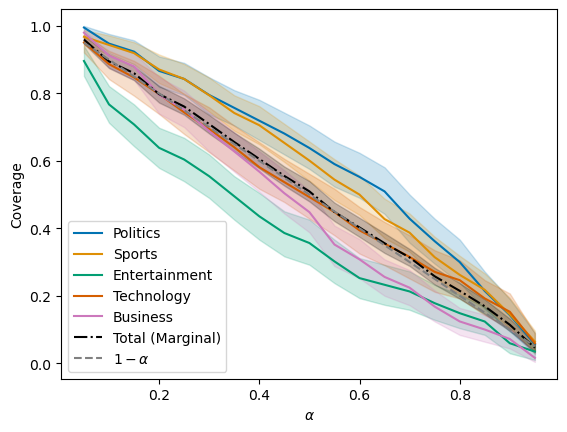

In [69]:
ax = sns.lineplot(data=coverage, x='alpha', y='covered', hue='true_label')
# remove legend title
sns.lineplot(data=coverage, x='alpha', y='covered', color='black', linestyle='-.', label="Total (Marginal)", ax=ax)
ax.plot(alphas, 1-alphas, color='gray', linestyle='--', label=r'$1-\alpha$')
ax.legend(title='', loc='lower left')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Coverage')
# add entry to legend for 1-alpha line
plt.savefig('../figures/nonadaptive_conditional_coverage.pdf', dpi=300, bbox_inches='tight')

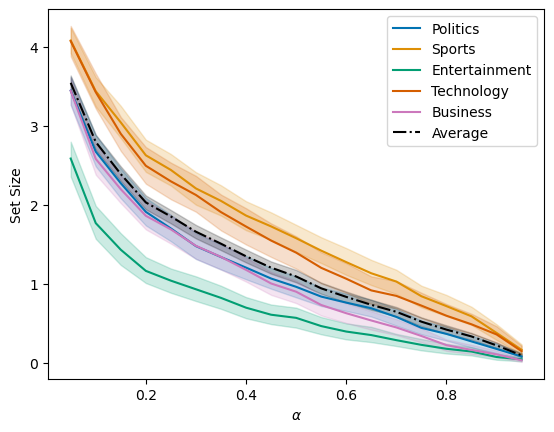

In [71]:
ax = sns.lineplot(data=coverage, x='alpha', y='set_size', hue='true_label')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Set Size')
sns.lineplot(data=coverage, x='alpha', y='set_size', color='black', linestyle='-.', label="Average", ax=ax)
ax.legend(title='', loc='upper right')
plt.savefig('../figures/nonadaptive_set_size.pdf', dpi=300, bbox_inches='tight')

## Adaptive conformal scoring

In [73]:
n = len(cal_labels)
# sort probabilities by most probable
cal_pi = cal_probs.values.argsort(axis=1)[:,::-1]
# cumulative sum of probabilities, sorted by most probable
cal_srt = np.take_along_axis(cal_probs.values, cal_pi, axis=1).cumsum(axis=1)
# calibration scores 
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1),axis=1)[range(n),cal_labels]


In [74]:
n = len(cal_labels)
alphas = np.arange(.05, 1, .05)
coverage = []
for alpha in alphas:
    # quantile of calibration scores
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    # compute validation set scores
    val_pi = val_probs.values.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(val_probs.values, val_pi, axis=1).cumsum(axis=1)
    # get prediction sets
    prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)
    # construct dataframe, determine coverage and set size
    pred_set_df = pd.DataFrame(prediction_sets, columns=list(candidate_labels.values()))
    pred_set_df['true_label'] = test_df['Label'].map(candidate_labels).values
    pred_set_df['covered'] = pred_set_df.apply(lambda x: x[x['true_label']], axis=1)
    pred_set_df['set_size'] = pred_set_df.apply(lambda x: x[list(candidate_labels.values())].sum(), axis=1)
    pred_set_df['alpha'] = alpha
    coverage.append(pred_set_df)
coverage = pd.concat(coverage)
coverage

,Politics,Sports,Technology,Entertainment,Business,true_label,covered,set_size,alpha
0,True,True,True,True,True,Politics,True,5,0.05
1,True,True,True,False,True,Sports,True,4,0.05
2,True,True,True,True,True,Entertainment,True,5,0.05
3,True,True,True,True,True,Politics,True,5,0.05
4,False,False,True,True,False,Technology,True,2,0.05
...,...,...,...,...,...,...,...,...,...
1108,False,False,False,False,False,Entertainment,False,0,0.95
1109,False,False,False,False,False,Technology,False,0,0.95
1110,False,False,False,False,False,Business,False,0,0.95
1111,False,False,False,False,False,Technology,False,0,0.95


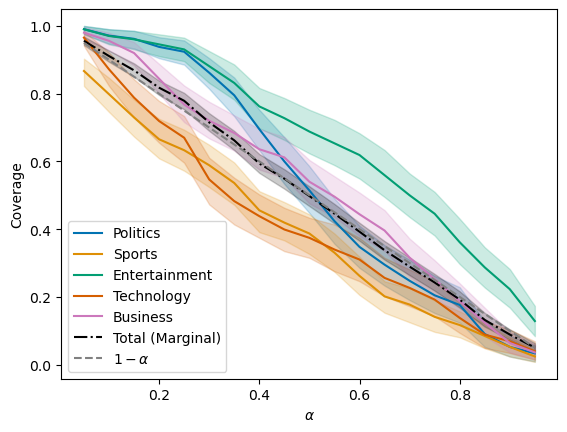

In [75]:
ax = sns.lineplot(data=coverage, x='alpha', y='covered', hue='true_label')
# remove legend title
sns.lineplot(data=coverage, x='alpha', y='covered', color='black', linestyle='-.', label="Total (Marginal)", ax=ax)
ax.plot(alphas, 1-alphas, color='gray', linestyle='--', label=r'$1-\alpha$')
ax.legend(title='', loc='lower left')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Coverage')
# add entry to legend for 1-alpha line
plt.savefig('../figures/adaptive_conditional_coverage.pdf', dpi=300, bbox_inches='tight')

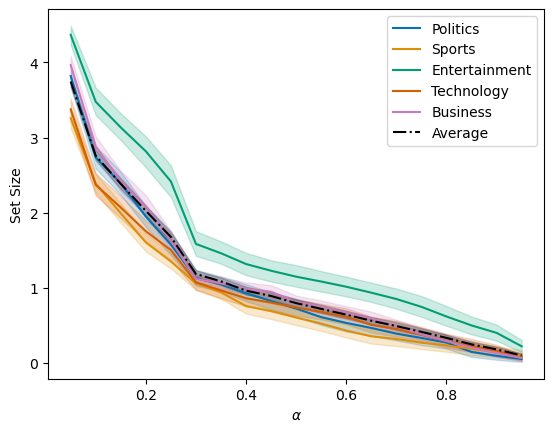

In [76]:
ax = sns.lineplot(data=coverage, x='alpha', y='set_size', hue='true_label')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Set Size')
sns.lineplot(data=coverage, x='alpha', y='set_size', color='black', linestyle='-.', label="Average", ax=ax)
ax.legend(title='', loc='upper right')
plt.savefig('../figures/adaptive_set_size.pdf', dpi=300, bbox_inches='tight')

# Evaluation

0.9510601976639712


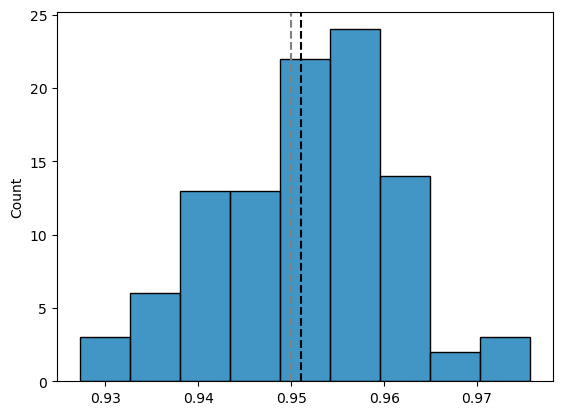

In [96]:
full_probs = pd.concat([cal_probs, val_probs])
full_labels = pd.concat([cal_labels, val_labels])
full_pi = full_probs.values.argsort(axis=1)[:,::-1]
full_srt = np.take_along_axis(full_probs.values, full_pi, axis=1).cumsum(axis=1)
scores = np.take_along_axis(full_srt, full_pi.argsort(axis=1),axis=1)[range(len(full_labels)),full_labels.values]

n = len(cal_labels)
R = 100
alpha = .05

coverages = np.zeros((R,)) 
for r in range(R): 
   np.random.shuffle(scores) # shuffle 
   calib_scores, val_scores = (scores[:n],scores[n:]) # split 
   qhat = np.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n, method='higher') # calibrate 
   coverages[r] = (val_scores <= qhat).astype(float).mean() 
average_coverage = coverages.mean() # should be close to 1-alpha 
print(average_coverage)
hist = sns.histplot(coverages, ec='k') # should be roughly centered at 1-alpha
plt.axvline(1-alpha, color='gray', linestyle='--')
plt.axvline(average_coverage, color='k', linestyle='--')